# The floe size distribution

## TO DO and thoughts:
- Add goodness of fit, Kolmogorov Smirnov test
- Does welding occur at a rate $r^2$ since it's area based?
- The pancake ice parameterisation seems pointless, can we improve upon this?
- 


The floe size distribution (FSD), $f(x)$, describes the variability of floe lengths over an area of sea ice cover. Typically in contemporary climate-scale models, the FSD is area-weighted, allowing for conservational principles for processes such as wave-induced fracturing of the sea ice. However, the number distribution, , is simpler to measure and has been used in waves-in-ice models due to its explicit quantification of floe edges, which can make attenuation problems easier to solve (e.g., *Kohout and Meylan, 2008*).

Moreover, both PDFs, $f(x)$, and complementary CDFs, $F(x)$, have been used to define the floe size distribution. Using the "number definition", $F(x)$ represents the number of floes greater than $x$ whereas $f(x)\mathrm{d}x$ is the fractional number of floes with lengths between $x$ and $x+\mathrm{d}x$ (Stern et al., 2018). Formally, a CDF is defined as
$$ F(x) = 1- P(X<x) = P(X>x)$$
$$ \therefore f(x) = -\frac{\mathrm{d}F(x)}{\mathrm{d}x}$$

To convert these to be functions of area Rothrock and Thorndike (1984) found a mean caliper ratio (floe area dived by the square mean caliper diameter) of 0.66.


## Distributions which describe the FSD
Many distributions have been fit to or to model the FSD, but they share similar constructions, e.g., power law, truncated power law, log-normals. Power laws (or truncated Pareto distributions) are related to the exponential distribution by the [following](https://en.wikipedia.org/wiki/Pareto_distribution#Relation_to_the_exponential_distribution):
If $X$ is Pareto-distributed with a minimum parameter, $x_{\mathrm{min}}$ and index $\alpha$, then
$$ Y = \log \left( \frac{X}{x_{\min}} \right) $$
is exponentially distributed with rate parameter $\alpha$. Equivalently, if $Y$ is exponentially distributed with rate $\alpha$, then
$$ x_{\min} e^Y $$
is Pareto-distributed with minimum $x_{\min}$ and index $\alpha$.

This can be shown using the standard change-of-variable techniques:
$$ {\begin{aligned}\Pr(Y<y)&=\Pr \left(\log \left({\frac {X}{x_{\mathrm {m} }}}\right)<y\right)\\&=\Pr(X<x_{\mathrm {m} }e^{y})=1-\left({\frac {x_{\mathrm {m} }}{x_{\mathrm {m} }e^{y}}}\right)^{\alpha }=1-e^{-\alpha y}.\end{aligned}} $$
The last expression is the cumulative distribution function of an exponential distribution with rate $\alpha$.


A similar relation exists between the log-normal and normal distributions.

### Log-normal distributions
[Source](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables):
The distribution of the product of two random variables which have lognormal distributions is again lognormal. This is itself a special case of a more general set of results where the logarithm of the product can be written as the sum of the logarithms. Thus, in cases where a simple result can be found in the list of convolutions of probability distributions, where the distributions to be convolved are those of the logarithms of the components of the product, the result might be transformed to provide the distribution of the product. However this approach is only useful where the logarithms of the components of the product are in some standard families of distributions.

### Normalising Williams et al. (2017)

1.	Power-law piece:

$$\int_{x_{\min}}^{x_{\rm crit}} C_1 x^{-(1+\gamma)} dx = C_1 \frac{x_{\min}^{-\gamma} - x_{\rm crit}^{-\gamma}}{\gamma}$$
	
2.	Uniform piece:
$$ \int_{x_{\rm crit}}^{x_{\max}} C_2 dx = C_2 (x_{\max} - x_{\rm crit}) = C_1 x_{\rm crit}^{-(1+\gamma)} (x_{\max} - x_{\rm crit}) $$

3. Solve for C_1
$$ C_1 \frac{x_{\min}^{-\gamma} - x_{\rm crit}^{-\gamma}}{\gamma} + C_1 x_{\rm crit}^{-(1+\gamma)} (x_{\max} - x_{\rm crit}) = 1 $$
$$ C_1 \left[ \frac{x_{\min}^{-\gamma} - x_{\rm crit}^{-\gamma}}{\gamma} + x_{\rm crit}^{-(1+\gamma)} (x_{\max} - x_{\rm crit}) \right] = 1 $$
$$
C_1 = \frac{1}{ \frac{x_{\min}^{-\gamma} - x_{\rm crit}^{-\gamma}}{\gamma} + x_{\rm crit}^{-(1+\gamma)} (x_{\max} - x_{\rm crit}) }
$$ 
Then
$$ C_2 = C_1 x_{\rm crit}^{-(1+\gamma)} $$

### Smoothing a split power law with two exponents

The piecewise PDF can be defined as:

$$
p(x) =
\begin{cases} 
P_0 \, \beta_0 \, \dfrac{\gamma_0}{x^{\gamma_0 + 1}}, & x < x_{\rm crit} \\[2mm]
p_{1,\rm crit} \, \dfrac{x_{\rm crit}^{(\gamma_1 + 1)}}{x^{(\gamma_1 + 1)}}, & x \ge x_{\rm crit}
\end{cases}
$$

where the normalization constants are:

$$
\beta_0 = \frac{1}{x_{\min}^{-\gamma_0} - x_{\rm crit}^{-\gamma_0}}, \quad
\beta_1 = x_{\rm crit}^{\gamma_1}
$$

and the value of $p_1$ at the transition is:

$$
p_{1,\rm crit} = P_0 \, \beta_0 \, \frac{\gamma_0}{x_{\rm crit}^{\gamma_0 + 1}}
$$

This ensures that the PDF is continuous at $x = x_{\rm crit}$:

$$
p_2(x_{\rm crit}) = p_{1,\rm crit} \, \left(\frac{x}{x_{\rm crit}}\right)^{-(\gamma_1 + 1)} = p_{1,\rm crit} = p_1(x_{\rm crit})
$$


In [443]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import powerlaw, lognorm
import seaborn as sns
sns.set(style='ticks')

from scipy.stats import norm

def subfn_floe_scaling(Dmin, Dmax, f=0.9, xi=2):
    """
    Computes the average floe size within a grid cell as a function of 
    the maximum floe size using a bounded fractal renormalization 
    group method.

    Taken from WIM1D: Tim Williams + Luke Bennetts

    Parameters
    ----------
    f : float
        Fractional coverage (0 < f < 1)
    xi : float
        Fractal parameter (> 0)
    Dmin : float
        Minimum floe size
    Dmax : float
        Maximum floe size

    Returns
    -------
    Dave : float
        Average floe size
    """

    # MAIN FORMULA (LGB CHANGE / Oct 2013)
    gam = 2 + np.log(f) / np.log(xi)
    Dave = gam * (Dmax * (Dmin / Dmax)**gam - Dmin) / (1 - gam)

    # ENSURE Dave >= Dmin
    Dave = max(Dave, Dmin)

    return Dave


def get_power_law_pdf(x_in, alpha, x_min=None, x_max=None):
    # Truncated Pareto (power-law) PDF on [min, max]
    if x_min is None:
        x_min = x_in.min()
    if x_max is None:
        x_max = x_in.max()
    C = (alpha - 1) * x_min**(alpha - 1) / (1 - (x_min / x_max)**(alpha - 1))
    return C * x_in**(-alpha)



def get_split_power_law_pdf(x, x_pr, gamma0=1.15, gamma1=2.5, x_crit=40, x_min=None, q=0.05):
    """Split (broken) power-law PDF on [min, inf].
    """
    if x_min is None:
        x_min = x.min()

    P0 = 1 - q * (x_pr / x_crit)**(gamma1)

    # Normalisation constants
    beta0 = 1/(x_min**(-gamma0) - x_crit**(-gamma0))
    C1 = P0 * beta0 * gamma0 #/ (x**(gamma0 + 1))

    # To make it smooth
    p1_xcrit = P0 * beta0 * gamma0 / x_crit**(gamma0 + 1)
    C2 = p1_xcrit * x_crit**(gamma1 + 1) #/  x **(gamma1 + 1)


    # Piecewise PDF
    pdf = np.where(
        x < x_crit,
        C1 * x**(-(gamma0 + 1)),
        C2 * x**(-(gamma1 + 1))
    )
    return pdf


def get_log_normal_pdf(x, mu, sigma, min=None, max=None):
    """Truncated lognormal PDF on [min, max]."""
    if min is None:
        min = x.min()
    if max is None:
        max = x.max()

    # Standardise truncation points
    za = (np.log(min) - mu) / sigma
    zb = (np.log(max) - mu) / sigma

    # Normalisation factor for truncation
    Z = norm.cdf(zb) - norm.cdf(za)

    # Base lognormal pdf
    pdf = (1 / (x * sigma * np.sqrt(2*np.pi))) * \
          np.exp(-(np.log(x) - mu)**2 / (2*sigma**2))

    return pdf / Z

# def get_single_power_law_dumont11_pdf():
    # fragility = 0.9
    # xi = 2
    # Dave = subfn_floe_scaling(Dmin, Dmax)



def get_power_law_williams13_pdf(x, alpha1, alpha2, x_crit, x_pr, x_min=None, x_max=None):
    """Continuous split (broken) power-law PDF on [min, inf].
    x_crit: critical floe size (transition point between power-laws)
    x_pr: predicted breakup floe size
    D_bk: Broken floe size
    D: Representative floe size
    """
    if x_min is None:
        x_min = x.min()
    if x_max is None:
        x_max = x.max()

    # q = 0.05
    gamma0 = alpha1 - 1
    gamma1 = alpha2 - 1

    P_max = 0.95 # a high probability
    # P0 = P(x < x_crit) can be found analytically

    # P0 = 1 - q * (x_pr / x_crit)**(gamma1)

    # Normalisation constants
    # beta0 = 1/(x_min**(-gamma0) - x_crit**(-gamma0))
    # p1 = P0 * beta0 * gamma0 / (x**(gamma0 + 1))

    # beta1 = x_crit**gamma1
    # p2 = (1-P0) * beta1 * gamma1 / (x**(gamma1 + 1))

    # To make it smooth
    # p1_xcrit = P0 * beta0 * gamma0 / x_crit**(gamma0 + 1)
    # p2 = p1_xcrit * (x / x_crit)**(-(gamma1 + 1))


    # Piecewise PDF
    pdf = np.where(
        x < x_crit,
        p1,
        p2
    )

    # D_bk_1 = (P0 * gamma0 * beta0 * (x_min**(1-gamma0) - x_crit**(1-gamma0))) / (gamma0-1) 
    # D_bk_2 =  ((1-P0) * gamma1 * beta1 / (gamma1 - 1) * x_crit**(1-gamma1))/(gamma1 - 1)
    # D_bk = D_bk_1 + D_bk_2

    return pdf, D_bk



def get_split_power_law_williams17_pdf(x, gamma=1.84, x_crit=200, x_min=None, x_max=None):
    """ Power law up until a critical point, uniform past that
    """
    if x_min is None:
        x_min = x.min()
    if x_max is None:
        x_max = x.max()

    # Default parameters
    # x_crit = 200 # m
    # gamma = 1.84
    # gamma = 2 + np.log(f)/log(zeta)
    # f = 0.9
    # zeta = 2

    p1 = ((gamma * x_min**gamma * x_max**gamma)/(x_max**gamma - x_min**gamma))* x**(-(1+gamma))
    p2 = 1 / (x_max - x_crit)

    C1 = 1 / ((x_min**(-gamma) - x_crit**(-gamma))/gamma + x_crit**(-(1+gamma))*(x_max - x_crit))
    C2 = C1 * x_crit**(-(1+gamma))

    # Piecewise PDF
    pdf = np.where(x < x_crit, 
                   C1 * x**(-(1+gamma)), 
                   C2
    )

    return pdf



def get_split_power_law_bennetts_pdf(x, x_pr, gamma0=1.15, gamma1=2.5, x_crit=40, x_min=None, q=0.05):
    """Split (broken) power-law PDF on [min, inf].
    x_crit: critical floe size (transition point between power-laws)
    x_pr: predicted breakup floe size
    D_bk: Broken floe size
    D: Representative floe size
    q: split of small to large floes
    """
    if x_min is None:
        x_min = x.min()

    P0 = 1 - q * (x_pr / x_crit)**(gamma1)

    # Normalisation constants
    beta0 = 1/(x_min**(-gamma0) - x_crit**(-gamma0))
    p1 = P0 * beta0 * gamma0 / (x**(gamma0 + 1))

    beta1 = x_crit**gamma1
    p2 = (1-P0) * beta1 * gamma1 / (x**(gamma1 + 1))

    # Piecewise PDF
    pdf = np.where(
        x < x_crit,
        p1,
        p2
    )

    D_bk_1 = (P0 * gamma0 * beta0 * (x_min**(1-gamma0) - x_crit**(1-gamma0))) / (gamma0-1) 
    D_bk_2 =  ((1-P0) * gamma1 * beta1 / (gamma1 - 1) * x_crit**(1-gamma1))/(gamma1 - 1)
    D_bk = D_bk_1 + D_bk_2

    return pdf, D_bk

def get_power_law_bateson(x, alpha, l_var, x_min=None, x_max=None):
    if x_min is None:
        x_min = x.min()
    if x_max is None:
        x_max = x.min()

    if np.any((alpha == 2) | (alpha == 3)):
        print("Invalid alpha, shifting it")
        alpha += 0.001 # Same as Bateson 2020

    # pdf = C * x ** (-alpha)
    x_out = x[x < l_var]
    pdf = get_power_law_pdf(x_out, alpha)
    num = (2 - alpha) * (l_var**(3-alpha) - x_min**(3-alpha))
    denom = ((3-alpha)*(l_var**(2-alpha) - x_min**(2-alpha)))
    l_eff = num / denom # Effective floe size


    return pdf, x_out, l_eff


Power law (Boutin) integrates to: 1.0040276425133732
Power law (Bateson) integrates to: 1.0024355726739824
Split power law integrates to: 0.9951960827532491
Split power law (Bennetts) integrates to: 0.9954132171449447
Split power law (Williams) integrates to: 1.0040075517901346
Log-normal integrates to: 0.9957397039154954


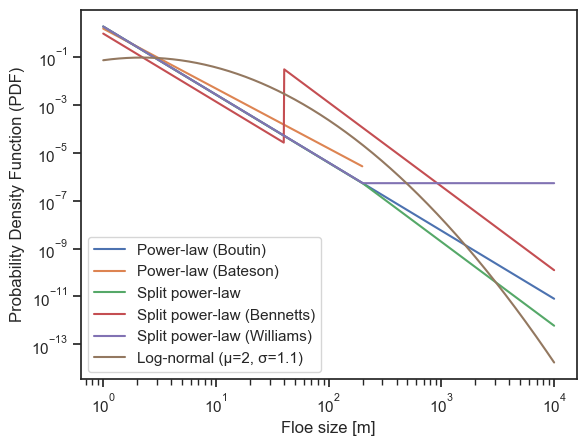

In [444]:
# Example of different distributions for the FSD
x = np.logspace(np.log10(1), np.log10(1e4), 1000)
dx = np.diff(x)
dx = np.concatenate(([dx[0]], dx))
alpha = 2.84
# mu = 10
# sigma = 100

mu = 2
sigma = 1.1


# alpha1 = 1.15 + 1 
# alpha = gamma + 1
# alpha2 = 2.5 + 1 
# x_crit = 40 # Something like this from Toyota
x_pr = 100 # Predicted breakup size, lambda/4
l_var = 200 # lambda/2 after breakup

gamma0 = 1.84
gamma1 = 2.5

# Dumont et al. (2011) values
fragility = 0.9
xi = 2


power_law = get_power_law_pdf(x, alpha=alpha)
power_law_boutin = get_power_law_pdf(x, alpha=gamma0+1) 
# But waves here modifies the maximum floe size like Batesons
# Bennetts15 using single power law with waves impact x_max
# power_law_bennetts15 = get_power_law_pdf(x, alpha=gamma0+1)
power_law_bateson, x_bateson, l_eff = get_power_law_bateson(x, alpha=2.5, l_var=l_var)
split_power_law = get_split_power_law_pdf(x, x_pr=x_pr, gamma0=gamma0, x_crit=200)
split_power_law_bennetts, x_broken = get_split_power_law_bennetts_pdf(x, x_pr=x_pr, gamma0=gamma0)
split_power_law_williams = get_split_power_law_williams17_pdf(x, x_crit=200, gamma=gamma0)
log_normal = get_log_normal_pdf(x, mu=mu, sigma=sigma)

# plt.plot(x, power_law, label='Power-law')
plt.plot(x, power_law_boutin, label=f'Power-law (Boutin)')
plt.plot(x_bateson, power_law_bateson, label=f'Power-law (Bateson)')
plt.plot(x, split_power_law, label=f'Split power-law')
plt.plot(x, split_power_law_bennetts, label=f'Split power-law (Bennetts)')
plt.plot(x, split_power_law_williams, label=f'Split power-law (Williams)')
plt.plot(x, log_normal, label=f'Log-normal (μ={mu}, σ={sigma})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Floe size [m]')
plt.ylabel('Probability Density Function (PDF)')
plt.legend()

# plt.axvline(x_broken)
# plt.axvline(l_eff)

dx_bateson = np.diff(x_bateson)
dx_bateson = np.concatenate(([dx_bateson[0]], dx_bateson))

print(f"Power law (Boutin) integrates to: {(power_law_boutin*dx).sum()}")
print(f"Power law (Bateson) integrates to: {(power_law_bateson*dx_bateson).sum()}")
print(f"Split power law integrates to: {(split_power_law*dx).sum()}")
print(f"Split power law (Bennetts) integrates to: {(split_power_law_bennetts*dx).sum()}")
print(f"Split power law (Williams) integrates to: {(split_power_law_williams*dx).sum()}")
print(f"Log-normal integrates to: {(log_normal*dx).sum()}")

In [445]:
# plt.plot(x, log_normal, label=f'Log-normal (μ={mu}, σ={sigma})')
# plt.xscale('log')
# # log_normal
# # del power_law

# split_power_law

## What is the best representative parameter for the floe size distribution?

Stern et al. (2018) Appendix B? 
- Can we calculate the MLE but assuming a power-law distribution which is then fed to the breakup criterion?
- Montiel and Mokus (2022) What about log-normal?

Questions:
- Have any "realistic" models outputted representative parameters?
    - Montiel, Mokus, Herman


In [446]:
ds = xr.open_dataset('/Users/daynd/Code/Github/sea-ice-models/FSD-breakup/data/iceh.2020-09-30.nc')
vars_to_keep = ['aice', 'hi', 'tarea', 'fsdrad', 'fsdperim', 'afsd', 'afsdn', 'wave_sig_ht', 'TLAT', 'TLON']   # example list
ds = ds[vars_to_keep]

ds = ds.isel(time=0).where(ds['TLAT'] < 0, drop=True).drop_vars('time')
ds

<xarray.Dataset> Size: 235MB
Dimensions:      (nj: 498, ni: 1440, nf: 12, nc: 5)
Coordinates:
    TLAT         (nj, ni) float32 3MB -81.08 -81.08 -81.08 ... -0.125 -0.125
    TLON         (nj, ni) float32 3MB 79.88 80.12 80.38 ... 79.12 79.38 79.62
    ULON         (nj, ni) float32 3MB -280.0 -279.8 -279.5 ... 79.25 79.5 79.75
    ULAT         (nj, ni) float32 3MB -81.02 -81.02 -81.02 ... 0.0 0.0 0.0
    NCAT         (nc) float32 20B ...
    NFSD         (nf) float32 48B ...
Dimensions without coordinates: nj, ni, nf, nc
Data variables:
    aice         (nj, ni) float32 3MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    hi           (nj, ni) float32 3MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    tarea        (nj, ni) float32 3MB 5.627e+07 5.627e+07 ... 7.728e+08
    fsdrad       (nj, ni) float32 3MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    fsdperim     (nj, ni) float32 3MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    afsd         (nf, nj, ni) float32 34MB nan nan nan nan ... 0.0 0.0 0.0 0.0
    afsdn        (nc, nf, nj, ni) float32 172MB nan nan nan nan ... 0.0 0.0 0.0
    wave_sig_ht  (nj, ni) float32 3MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model, CICE_6.2.0
    comment:      This year has 366 days
    comment2:     File written on model date 20201001
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2025-11-12 at 03:07:13.0
    io_flavor:    io_netcdf

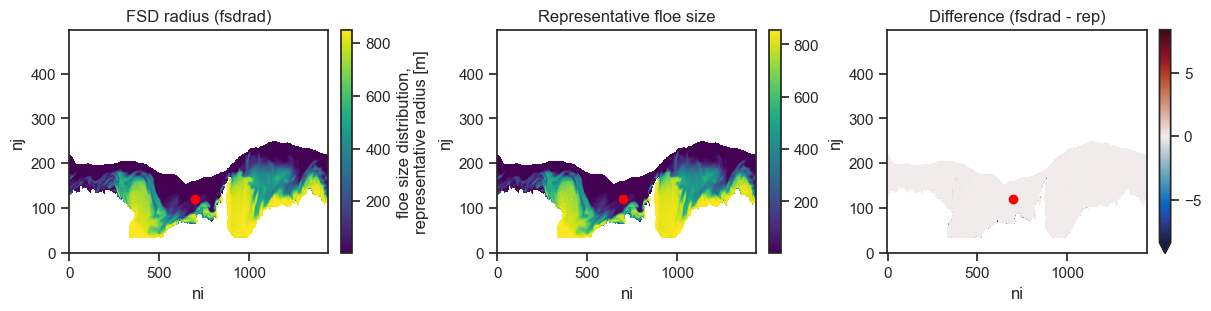

In [447]:
def ciceBinWidths(NFSD):
    """
    Return the bin widths used in CICE.

    Args:
        NFSD (ndarray): Floe bin centres [m]

    Returns:
        BinWidths (ndarray): Binwidths [m]
        BinLeft (ndarray): Binwidths [m]
        BinRight (ndarray): Binwidths [m]
    """
    min_floe = 6.65000000e-02;
    # Define arrays
    fsd_lims = np.zeros(len(NFSD)+1)
    floe_rad_c = np.zeros(len(NFSD))
    floe_rad_l = np.zeros(len(NFSD))
    floe_rad_h = np.zeros(len(NFSD))
    
    fsd_lims[0] = min_floe;
    for i in range(len(NFSD)):
        fsd_lims[i+1] = 2*NFSD[i] - fsd_lims[i]
        floe_rad_c[i] = NFSD[i]
    
    
    floe_rad_l = fsd_lims[0:-1]
    floe_rad_h = fsd_lims[1:]
    floe_binwidth = floe_rad_h - floe_rad_l
    
    floeshape = 0.66;
    floe_area_l = 4*floeshape*floe_rad_l**2
    # floe_area_c = 4*floeshape*floe_rad_c**2
    floe_area_h = 4*floeshape*floe_rad_h**2
    floe_area_c = (floe_area_h + floe_area_l)/2
    
    
    BinWidths = floe_rad_h - floe_rad_l
    BinRight = floe_rad_h
    BinLeft = floe_rad_l

    return BinWidths, BinLeft, BinRight, floe_area_c, floe_area_l, floe_area_h


def get_representative_floe_size(NFSD_in, afsd_in, aice_in):
    floe_binwidth = NFSD_in.copy()
    floe_binwidth.values, _, _, _, _, _ = ciceBinWidths(NFSD_in)
    afsd_in = afsd_in * floe_binwidth
    Nf = len(NFSD_in)
    rep_floe_size = (afsd_in*NFSD /aice_in).sum(dim='nf') 
    return rep_floe_size


import matplotlib.pyplot as plt
import cmocean.cm as cmo

# Apply the mask for Southern Hemisphere and ice concentration > 0.15
mask = (ds['aice'] > 0.15)# & (ds['TLAT'] < 0)

fsdrad_plot = ds['fsdrad'].where(mask, drop=False)
afsd_plot = ds['afsd'].where(mask, drop=False)
aice_plot = ds['aice'].where(mask, drop=False)
NFSD = ds['NFSD']

rep_floe_size_map = get_representative_floe_size(NFSD_in=NFSD, afsd_in=afsd_plot, aice_in=aice_plot)

# Calculate difference
diff = fsdrad_plot - rep_floe_size_map

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(12,3), constrained_layout=True)

fsdrad_plot.plot(ax=axes[0], cmap='viridis')
axes[0].set_title('FSD radius (fsdrad)')

rep_floe_size_map.where(mask).plot(ax=axes[1], cmap='viridis')
axes[1].set_title('Representative floe size')

diff.plot(ax=axes[2], cmap=cmo.balance, vmin=-diff.max(), vmax=diff.max())
axes[2].set_title('Difference (fsdrad - rep)')

# Location in the outer MIZ
# ni_idx = 700
# nj_idx = 150

# Location in the MIZ
ni_idx = 700
nj_idx = 120

# Location in the inner pack
# ni_idx = 700
# nj_idx = 80

for ax in axes:
    ax.scatter(ni_idx, nj_idx, color='red')

plt.show()


In [448]:
x = ds['NFSD']
# Select only cells with aice > 0.15 and TLAT < 0
mask = (ds['aice'] > 0.15) & (ds['TLAT'] < 0)
binwidths, floe_rad_l, floe_rad_r = ciceBinWidths(NFSD)

# Area-weighted average function
def area_weighted_mean(var_in, area_in, mask_in):
    masked_var = var_in.where(mask_in)
    masked_area = area_in.where(mask_in)
    return (masked_var * masked_area).sum(dim=['ni','nj']) / masked_area.sum(dim=['ni','nj'])

# Apply to your variables
afsd = area_weighted_mean(var_in=ds['afsd'], area_in=ds['tarea'], mask_in=mask)
norm_afsd = area_weighted_mean(var_in=(ds['afsd']/ds['aice']), area_in=ds['tarea'], mask_in=mask)
aice = area_weighted_mean(var_in=ds['aice'], area_in=ds['tarea'], mask_in=mask)
fsdrad = area_weighted_mean(var_in=ds['fsdrad'], area_in=ds['tarea'], mask_in=mask)

rep_floe_size = get_representative_floe_size(NFSD_in=x, afsd_in=afsd, aice_in=aice)

fsd_pdf = afsd / np.sum(afsd * binwidths)

x_plot = np.logspace(np.log10(1), 10, 50)
simple_power_law = get_power_law_pdf(x_plot, alpha=2.2)

plt.plot(x, afsd, marker='o')
# plt.plot(x, fsd_pdf, marker='o')
plt.plot(x_plot, simple_power_law)
plt.xlabel('Floe radius [m]')
plt.ylabel('Area-weighted FSD [m$^{-1}$]')

plt.axvline(rep_floe_size, color='tab:red', linestyle='-', label='Representative floe size')
plt.axvline(fsdrad, color='tab:blue', linestyle='--', label='$r_a$ from CICE')
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.xlim(5e-1, 1000)
plt.ylim(1e-12, 1e1)

ValueError: too many values to unpack (expected 3)

In [ ]:
dx = np.diff(x_plot)
dx = np.concatenate(([dx[0]], dx))
(simple_power_law*dx).sum()

np.float64(1.31379410470249)

In [ ]:
(fsd_pdf*binwidths).sum()

<xarray.DataArray ()> Size: 8B
array(1.)

In [ ]:
floe_rad_l

array([6.65000000e-02, 5.31030864e+00, 1.42865866e+01, 2.90576670e+01,
       5.24122122e+01, 8.78691446e+01, 1.39518459e+02, 2.11635777e+02,
       3.08037258e+02, 4.31203098e+02, 5.81277187e+02, 7.55141026e+02])

### Calculating the MLE for a power-law distribution
Following Stern et al. (2018) Appendix:
Consider a power-law PDF, $f(x) = C x^{-\alpha}$ on the finite interval $a \leq x \leq b$, where $a > 0$. (This is also known as a truncated Pareto distribution, e.g., by White et al., 2008.) The normalisation constant, $c$, is determined by 
$$ \int_a^b f(x) \mathrm{d}x = 1, $$
hence, 
$$ C = \frac{(\alpha - 1)a^{\alpha - 1}}{ 1 - \left( \frac{a}{b} \right)^{\alpha - 1}}. $$

In [ ]:
# rep_floe_size

We want to solve for $\alpha$ for
$$ \alpha = 1 + \left[ \ln\left(\frac{G}{a}\right) +  \frac{\ln(r)}{r^{\alpha - 1} - 1} \right]^{-1} \equiv H(\alpha)  $$
where we have defined the right-hand size of the equation to be a function $H(\alpha)$. The method of solution is simple: start with an initial guess $\alpha = \alpha_0$ and calculate $\alpha_1 = H(\alpha_0)$. Continue with $\alpha_2 = H(\alpha_1)$, and so on.

In [ ]:
def geometric_mean(data):
    return np.exp(np.mean(np.log(data)))

# def mle_power_law(alpha_in, a_in, b_in, G_in):
#     r = b_in / a_in
#     return 1 + 1.0 / (np.log(G_in / a_in) + np.log(r) / (r**(alpha_in - 1) - 1))


In [ ]:
# import numpy as np
# import xarray as xr

# # -------------------------------
# # Functions for analysis
# # -------------------------------

# def power_law_pdf(x_in, alpha_in, a_in, b_in):
#     C = (alpha_in - 1) * a**(alpha_in - 1) / (1 - (a_in / b_in)**(alpha_in - 1))
#     print(C)
#     return C * x_in**(-alpha_in)

# def geometric_mean(arr):
#     return np.exp(np.mean(np.log(arr)))

# def estimate_power_law_alpha(fsd, min_size=None, max_size=None, mean=None, initial_guess=1.1, tol=1e-12, max_iter=10000):
#     """
#     Estimate the power-law exponent (alpha) from a floe size distribution (FSD).
    
#     Parameters
#     ----------
#     fsd : np.ndarray or xarray.DataArray
#         FSD values (can be area-weighted or probability-like, must be > 0).
#     min_size : float, optional
#         Lower bound of the FSD (if None, uses min of fsd array).
#     max_size : float, optional
#         Upper bound of the FSD (if None, uses max of fsd array).
#     initial_guess : float
#         Initial guess for alpha in iterative MLE.
#     tol : float
#         Convergence tolerance.
#     max_iter : int
#         Maximum number of iterations.
        
#     Returns
#     -------
#     alpha : float
#         Estimated power-law exponent.
#     G : float
#         Geometric mean (representative size) used in the estimation.
#     """
    
#     # Convert to NumPy array if xarray
#     if isinstance(fsd, xr.DataArray):
#         fsd = fsd.values
    
#     fsd = np.array(fsd, dtype=float)
    
#     # Remove zeros and NaNs
#     fsd = fsd[fsd > 0]
#     if fsd.size == 0:
#         raise ValueError("FSD array contains no positive values.")
    
#     # Bounds
#     a = min_size if min_size is not None else fsd.min()
#     b = max_size if max_size is not None else fsd.max()
    
#     # Representative size: geometric mean
#     G = mean if mean is not None else geometric_mean(fsd)

#     print("a = ", a)
#     print("b = ", b)
#     print("G = ", G)
    
#     # Iterative MLE function
#     def mle_step(alpha_in, a_in, b_in, G_in):
#         r = b_in / a_in
#         return 1 + 1.0 / (np.log(G_in / a_in) + (np.log(r) / (r**(alpha_in - 1) - 1)))
    
#     alpha_guess = initial_guess
#     for i in range(max_iter):
#         alpha_new = mle_step(alpha_guess, a, b, G)
#         if abs(alpha_new - alpha_guess) < tol:
#             break
#         alpha_guess = alpha_new
#     else:
#         print("Warning: MLE did not converge within max_iter iterations.")
    
#     print("Converged in", i+1, "iterations.")
#     alpha = alpha_new
#     return alpha, G

# # Synthetic power-law sample
# # np.random.seed(42)
# true_alpha = 2.5
# N = 1000
# a = 1.0
# b = 100.0
# u = np.random.rand(N)
# samples = ((u * (b**(1-true_alpha) - a**(1-true_alpha)) + a**(1-true_alpha)))**(1/(1-true_alpha))

# # Estimate alpha
# alpha_est, G_est = estimate_power_law_alpha(samples)
# print(f"Estimated alpha: {alpha_est:.6f}, True alpha: {true_alpha}")
# # print(f"Representative size G: {G_est:.3f}")

# del true_alpha, N, a, b, u, samples, alpha_est, G_est

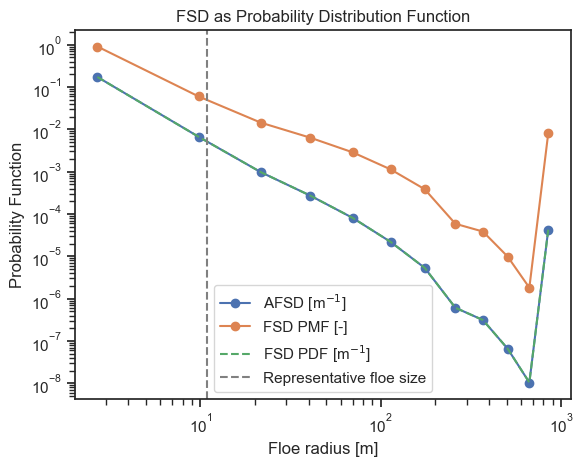

In [ ]:
# -------------------------------
# Load and preprocess FSD data
# -------------------------------
x = ds['NFSD'].values
# afsd = ds['afsd'].where(ds['aice'] > 0.15).where(ds['TLAT'] < 0, drop=True).mean(dim=['ni', 'nj'])
# FSD of a single cell
afsd = ds['afsd'].where(ds['aice'] > 0.15).where(ds['TLAT'] < 0, drop=True).isel(ni=ni_idx, nj=nj_idx)

rep_floe_size = get_representative_floe_size(NFSD_in=ds['NFSD'], afsd_in=afsd, aice_in=ds['aice'].isel(ni=ni_idx, nj=nj_idx))
# Convert FSD to probability distribution
afsd
binwidths, floe_rad_l, floe_rad_r = ciceBinWidths(NFSD)
binwidths

fsd_pmf = afsd * binwidths
fsd_pdf = afsd / np.sum(afsd * binwidths)
# fsd_pmf /= fsd_pmf.sum()

plt.plot(x, afsd, marker='o', label='AFSD [m$^{-1}$]')
plt.plot(x, fsd_pmf, marker='o', label='FSD PMF [-]')
plt.plot(x, fsd_pdf, ls='--', label='FSD PDF [m$^{-1}$]')

plt.axvline(rep_floe_size, color='gray', linestyle='--', label='Representative floe size')
# plt.plot(x_sub, fsd_pmf_sub, marker='o', label='Subsampled FSD PMF')
plt.xlabel('Floe radius [m]')
plt.ylabel('Probability Function')
plt.xscale('log')
plt.yscale('log')
plt.title('FSD as Probability Distribution Function')
plt.legend()

In [ ]:
fsd_pmf


<xarray.DataArray 'afsd' (nf: 12)> Size: 96B
array([9.06571720e-01, 5.99003563e-02, 1.44024435e-02, 6.36020002e-03,
       2.85942344e-03, 1.13243140e-03, 3.85797267e-04, 5.88028460e-05,
       3.84877279e-05, 9.89180454e-06, 1.81801366e-06, 8.13157004e-03])
Coordinates:
    TLAT     float32 4B -68.41
    TLON     float32 4B 254.9
    ULON     float32 4B -105.0
    ULAT     float32 4B -68.35
    NFSD     (nf) float32 48B 2.688 9.798 21.67 40.73 ... 506.2 668.2 850.5
Dimensions without coordinates: nf

In [ ]:
# from scipy.interpolate import interp1d
# from scipy.interpolate import UnivariateSpline

# truncate_distribution = True
# interpolate_on = False

# if truncate_distribution:
#     # Optionally remove last few bins if they are zeros/artifacts
#     floe_size_min = 1
#     floe_size_max = 200
#     mask = (x >= floe_size_min) & (x < floe_size_max)
#     x_train = x[mask]
#     afsd_train = afsd[mask]
#     fsd_pmf_train = fsd_pmf.values[mask]
#     # fsd_pmf_train = fsd_pmf_train* binwidths[mask]
#     fsd_pmf_train = fsd_pmf_train/fsd_pmf_train.sum()
# else:
#     x_train = x
#     afsd_train = afsd
#     fsd_pmf_train = fsd_pmf.values
#     fsd_pdf_train = fsd_pdf.values


# if interpolate_on:
#     # Interpolation grid: high-resolution log-spaced
#     x_fine = np.logspace(np.log10(x_train[0]), np.log10(x_train[-1]), 1000)
#     spline = UnivariateSpline(np.log(x_train), np.log(fsd_pmf_train), k=3, s=0)
#     fsd_fine = np.exp(spline(np.log(x_fine)))

#     # Normalize to probability distribution
#     x_sample = x_fine
#     prob = fsd_fine / fsd_fine.sum()

# else:
#     x_sample = x_train
#     prob = fsd_pmf_train/fsd_pmf_train.sum()
#     prob = np.atleast_1d(prob)
#     bin_edge_left = floe_rad_l
#     bin_edge_right = floe_rad_r
    
   

# # -------------------------------
# # Draw samples
# # -------------------------------

# def sample_from_binned_pdf(bin_left, bin_right, pmf_bins, N):
#     """
#     Draw N samples from a piecewise-constant PDF defined by pmf_bins
#     over bins [bin_left[i], bin_right[i]].
#     """
#     pmf_bins = np.asarray(pmf_bins)
#     pmf_bins = pmf_bins / pmf_bins.sum()     # ensure normalization
    
#     # Choose which bin each sample falls into
#     bins = np.arange(len(pmf_bins))
#     chosen_bins = np.random.choice(bins, size=N, p=pmf_bins)
    
#     # Sample uniformly within each bin
#     u = np.random.rand(N)
#     samples = bin_left[chosen_bins] + u * (bin_right[chosen_bins] - bin_left[chosen_bins])
#     return samples


# sampling = False

# if sampling: 
#     # if you have centers x and dx, make edges:
#     N_samples = 10000
#     samples = sample_from_binned_pdf(bin_edge_left, bin_edge_right, prob, N_samples)
#     # samples = np.random.choice(x_sample, size=N_samples, p=prob)
#     # -------------------------------
#     # Estimate power-law exponent and geometric mean
#     # -------------------------------
#     G = geometric_mean(samples)
#     alpha_est, G_est = estimate_power_law_alpha(samples, mean=G)
#     # alpha_est, G_est = estimate_power_law_alpha(samples)

#     print(f"Estimated power-law exponent: {alpha_est:.3f}")
#     print(f"Representative floe size (geometric mean): {G_est:.2f} m")
#     # -------------------------------
#     # Plot histogram and fitted power-law
#     # -------------------------------
#     # Power-law PDF for plotting
#     a = samples.min()
#     b = samples.max()
# else:
#     # Just use the data provided
#     a = bin_edge_left.min()
#     b = bin_edge_right.max()
#     alpha_est, G_est = estimate_power_law_alpha(afsd_train, min_size




# C = (alpha_est - 1) * a**(alpha_est - 1) / (1 - (a / b)**(alpha_est - 1))
# power_law_pdf = C * x_sample**(-alpha_est)

# power_law_pmf = power_law_pdf * binwidths[mask]
# power_law_pmf = power_law_pmf / power_law_pmf.sum()


# # plt.plot(x, fsd/fsd.sum(), '-', label=' FSD')
# # Normalize original FSD to probability density over bins
# # fsd_sub_norm = afsd_sub / np.sum(afsd_sub * np.diff(np.hstack([x_sub, x_sub[-1]+1])))
# # plt.plot(x_sub, fsd_sub_norm, 's-', label='Original FSD')

# # plt.plot(x, fsd_pmf, marker='o', label='FSD PMF')


# plt.figure(figsize=(7,5))
# bins = np.hstack([floe_rad_l[0], floe_rad_r])
# bin_counts, bin_edges = np.histogram(samples, bins=bins, density=False)
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# bin_heights_pmf = bin_counts / bin_counts.sum()  # sums to 1

# plt.plot(bin_centers, bin_heights_pmf, '*', markersize=10, label='Sample binned heights')

# plt.plot(x, fsd_pmf, marker='o', label='FSD PMF')
# plt.plot(x, fsd, marker='o', label='FSD Area-weighted')
# plt.plot(x_sample, power_law_pdf, '-', label='Fitted power-law PDF')
# if interpolate_on:
#     plt.plot(x_fine, fsd_fine, '-', label='Spline')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Floe radius [m]')
# plt.ylabel('Probability density')
# plt.legend()
# plt.show()


In [ ]:
# # PDF checks
# print("Sum of fitted power-law PDF:", np.sum(power_law_pdf * np.diff(np.hstack([x_sample, x_sample[-1]+1]))))
# print("Sum of original FSD PMF:", fsd_pmf_sub.sum())
# print("Sum of original FSD PMF:", bin_centers.sum())

# # bin_counts

In [ ]:
# print(fsd_pmf)
# print(x)

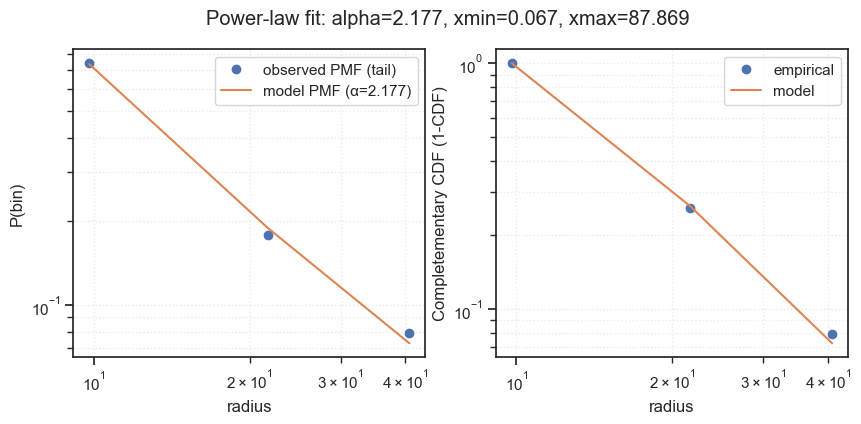

In [ ]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# --- Inputs (use your variable names) ---
# x: bin centers (NFSD)
# floe_rad_l, floe_rad_r: left/right bin edges (same length as x)
# fsd_pdf: PDF per metre (normalized such that sum(pdf*binwidths)==1)
# Example names based on your code:
# x = ds['NFSD'].values
# floe_rad_l, floe_rad_r = floe_rad_l, floe_rad_r  # replace with your arrays
# fsd_pdf = fsd_pdf   # your pdf array

# ---------- helper model functions ----------
def bin_probabilities_given_alpha(alpha, L, R, a, b):
    """
    Model probability for each bin [L_i,R_i) for continuous power-law ~ x^{-alpha}
    normalized on [a,b].
    Returns array P_i of same length as L,R.
    """
    L = np.asarray(L, dtype=float)
    R = np.asarray(R, dtype=float)
    # handle alpha close to 1 safely using limit
    if abs(alpha - 1.0) < 1e-8:
        num = np.log(R / L)
        den = np.log(b / a)
    else:
        # integral of x^{-alpha} dx = (x^{1-alpha})/(1-alpha)
        num = (L**(1.0 - alpha) - R**(1.0 - alpha)) / (1.0 - alpha)
        den = (a**(1.0 - alpha) - b**(1.0 - alpha)) / (1.0 - alpha)
    P = num / den
    # numerical safety
    P = np.maximum(P, 1e-300)
    return P

def neg_log_likelihood(alpha, L, R, pmf_obs, a, b):
    P = bin_probabilities_given_alpha(alpha, L, R, a, b)
    # pmf_obs are observed probabilities per bin (sum to 1 over used bins)
    return -np.sum(pmf_obs * np.log(P))

# ---------- main fit routine ----------
def fit_binned_powerlaw_from_pdf(bin_left, bin_right, pdf, scan_xmins=None, scan_xmaxs=None,
                                 exclude_last_bin_if_open=True,
                                 alpha_bounds=(0.0001, 50.0)):
    """
    Fit power-law exponent alpha from a PDF given per-bin.
    - bin_left, bin_right : arrays of bin edges (len K)
    - pdf : PDF values per bin center (units 1/length). Should satisfy sum(pdf*binwidth)=1 (or will be normalized).
    - scan_xmins : iterable of candidate xmins (left-edge values). If None, fit using full range.
    - exclude_last_bin_if_open : if True and last bin right is inf or extremely large, exclude it by default.
    Returns best result dict with keys: alpha, xmin, P_model, pmf_obs, success, res.
    """
    bin_left = np.asarray(bin_left, dtype=float)
    bin_right = np.asarray(bin_right, dtype=float)
    pdf = np.asarray(pdf, dtype=float)

    # bin widths and PMF from PDF
    widths = bin_right - bin_left
    # if pdf isn't normalized, normalize it to integrate to 1
    pdf = pdf / np.sum(pdf * widths)
    pmf = pdf * widths
    pmf = pmf / pmf.sum()

    # detect open last bin (right edge infinite or nan/very large)
    if exclude_last_bin_if_open:
        if not np.isfinite(bin_right[-1]) or bin_right[-1] > 1e8:
            # drop the last bin (commonly an open-ended overflow bin)
            bin_left = bin_left[:-1]
            bin_right = bin_right[:-1]
            pdf = pdf[:-1]
            widths = widths[:-1]
            pmf = pmf[:-1]

    # candidate xmins (left edges) to scan
    if scan_xmins is None:
        # default: consider fitting tail starting from each bin left, but skip tiny tails
        scan_xmins = bin_left
    

    if scan_xmaxs is None:
        scan_xmaxs = bin_right

    best = {'alpha': None, 'xmin': None, 'nll': np.inf, 'res': None, 'pmf_obs': None, 'P_model': None}

    for xmin in np.unique(scan_xmins):
        for xmax in np.unique(scan_xmaxs):
            # choose bins whose left edge >= xmin (i.e. fit tail bins)
            mask = (bin_left > xmin) & (bin_right < xmax) #& (pdf < 1e-18) # use bins that overlap the tail region
            if mask.sum() < 3:
                continue
            L = bin_left[mask]
            R = bin_right[mask]
            pmf_obs = pmf[mask]
            # renormalize pmf_obs so it sums to 1 over the selected bins
            pmf_obs = pmf_obs / pmf_obs.sum()
            a = L[0]
            b = R[-1]
            # minimize negative log-likelihood wrt alpha
            res = optimize.minimize_scalar(neg_log_likelihood, bounds=alpha_bounds, method='bounded',
                                        args=(L, R, pmf_obs, a, b))
            if not res.success:
                continue
            nll = res.fun
            if nll < best['nll']:
                best.update({
                    'alpha': res.x,
                    'xmin': xmin,
                    'xmax': xmax,
                    'nll': nll,
                    'res': res,
                    'pmf_obs': pmf_obs,
                    'P_model': bin_probabilities_given_alpha(res.x, L, R, a, b),
                    'L': L, 'R': R
                })

    # final diagnostics
    if best['alpha'] is None:
        raise RuntimeError("No successful fit found. Try widening scan_xmins or relaxing alpha_bounds.")
    return best

# ---------- Usage with your variables ----------
# Replace the names below with your arrays in the environment
# Example: x, floe_rad_l, floe_rad_r, fsd_pdf
# best = fit_binned_powerlaw_from_pdf(floe_rad_l, floe_rad_r, fsd_pdf, scan_xmins=floe_rad_l[1:])
# If you want to force fitting full range: scan_xmins = [floe_rad_l[0]]

# --- run the fit (uncomment and adapt names) ---
# best = fit_binned_powerlaw_from_pdf(floe_rad_l, floe_rad_r, fsd_pdf, scan_xmins=floe_rad_l[1:])

# ---------- plotting diagnostics ----------
def plot_fit_diagnostics(best, show_complement_CDF=False):
    alpha = best['alpha']
    xmin = best['xmin']
    xmax = best['xmax']
    L = best['L']; R = best['R']
    pmf_obs = best['pmf_obs']
    P_model = best['P_model']
    centers = 0.5*(L+R)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.loglog(centers, pmf_obs, 'o', label='observed PMF (tail)')
    plt.loglog(centers, P_model, '-', label=f'model PMF (α={alpha:.3f})')
    plt.xlabel('radius'); plt.ylabel('P(bin)')
    plt.legend(); plt.grid(True, which='both', ls=':', alpha=0.4)

    if show_complement_CDF:
        # observed survival (cumulative from tail)
        # compute observed survival at the bin-left edges (cumulative tail)
        cum_obs = np.cumsum(pmf_obs[::-1])[::-1]  # survival per bin (starts at first tail bin)
        # model survival: cumulative sum of model bin probs
        cum_model = np.cumsum(P_model[::-1])[::-1]
        plt.subplot(1,2,2)
        plt.loglog(centers, cum_obs, 'o', label='empirical')
        plt.loglog(centers, cum_model, '-', label='model')
        plt.xlabel('radius'); plt.ylabel('Completementary CDF (1-CDF)')
        plt.legend(); plt.grid(True, which='both', ls=':', alpha=0.4)

    plt.suptitle(f"Power-law fit: alpha={alpha:.3f}, xmin={xmin:.3f}, xmax={xmax:.3f}")
    plt.show()

# ---------- Example run (uncomment & run) ----------
# example: exclude bins with left edge > xmax
xmax = 200  # meters, adjust according to your data
mask = floe_rad_r <= xmax

best = fit_binned_powerlaw_from_pdf(
    floe_rad_l[mask],
    floe_rad_r[mask],
    fsd_pdf[mask],
    # scan_xmins=floe_rad_l[mask]  # candidate xmin in this truncated range
)
plot_fit_diagnostics(best, show_complement_CDF=True)

In [ ]:
def get_power_law_pdf(x, alpha, a, b):
    C = (alpha - 1) * a**(alpha - 1) / (1 - (a / b)**(alpha - 1))
    return C * x**(-alpha)

# alpha_est = best['alpha']
# a = best['xmin']
# b = best['xmax']

# C = (alpha_est - 1) * a**(alpha_est - 1) / (1 - (a / b)**(alpha_est - 1))
# power_law_pdf = C * x**(-alpha_est)



# PDF checks
# print("Sum of fitted power-law PDF:", np.sum(power_law_pdf*binwidths))


power_law_pdf = get_power_law_pdf(x=x, alpha=best['alpha'], a=best['xmin'], b=best['xmax'])  # left/right edges
# power_law_pdf = get_power_law_pdf(x=x, alpha=best['alpha'], a=x.min(), b=x.min()) 

def truncated_bin_pmf(alpha, L, R, a, b):
    """Return exact probability mass per bin for a truncated power-law."""
    if abs(alpha - 1) < 1e-8:
        # handle alpha ~ 1
        P = np.log(R/L) / np.log(b/a)
    else:
        P = (L**(1-alpha) - R**(1-alpha)) / (a**(1-alpha) - b**(1-alpha))
    return P

power_law_pmf = truncated_bin_pmf(alpha=best['alpha'], L=floe_rad_l, R=floe_rad_r, a=best['xmin'], b=best['xmax'])
print(f"alpha = {best['xmin']}, xmin = {best['xmin']}, xmax = {best['xmax']}")
print("Sum over bins (exact PMF):", power_law_pmf.sum())  # =1 exactly     

alpha = 0.0665, xmin = 0.0665, xmax = 87.86914462661744
Sum over bins (exact PMF): 1.0001987598290805


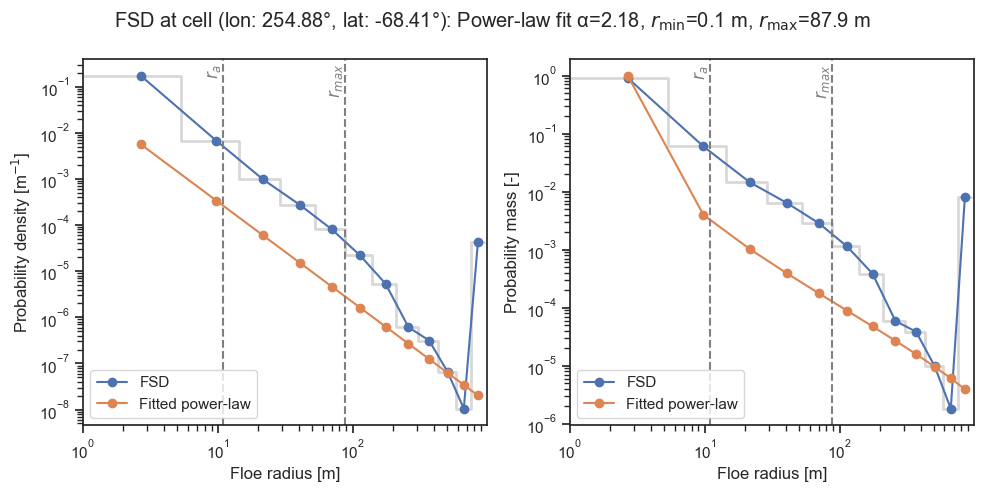

In [ ]:
def plot_step(ax, floe_rad_l, floe_rad_r, pdf_values, **plot_kwargs):
    # expand edges for step plotting
    x_step = np.empty(2 * len(floe_rad_l))
    y_step = np.empty_like(x_step)

    x_step[0::2] = floe_rad_l
    x_step[1::2] = floe_rad_r

    y_step[0::2] = pdf_values
    y_step[1::2] = pdf_values

    # step plot
    ax.plot(x_step, y_step, '-', linewidth=2, **plot_kwargs)



import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# ---------- Left subplot: raw PDFs ----------
# axes[0].step(floe_rad_l, floe_rad_r, fsd_pdf, where='mid', label='FSD Area-weighted', linewidth=2, alpha=0.1)
plot_step(axes[0], floe_rad_l, floe_rad_r, fsd_pdf, color='gray', alpha=0.3)
axes[0].plot(x, fsd_pdf, marker='o', label='FSD')
axes[0].plot(x, power_law_pdf, marker='o', label='Fitted power-law')

axes[0].set_ylabel('Probability density [m$^{-1}$]')

# ---------- Right subplot: normalized by max ----------
# plot_step(axes[1], floe_rad_l, floe_rad_r, fsd_pdf/(fsd_pdf.max()), color='gray', alpha=0.3)
# axes[1].plot(x, fsd_pdf/fsd_pdf.max(), marker='o', label='FSD Area-weighted')
# axes[1].plot(x, power_law_pdf/power_law_pdf.max(), marker='o', label='Fitted power-law PDF')
plot_step(axes[1], floe_rad_l, floe_rad_r, fsd_pmf, color='gray', alpha=0.3)
axes[1].plot(x, fsd_pmf, marker='o', label='FSD')
axes[1].plot(x, power_law_pmf, marker='o', label='Fitted power-law')
axes[1].set_ylabel('Probability mass [-]')

for ax in axes:
    ax.set_xlim(left=1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Floe radius [m]')
    # ax.axvline(best['xmin'], color='gray', linestyle='--')
    ax.axvline(best['xmax'], color='gray', linestyle='--')
    ax.axvline(rep_floe_size, color='gray', linestyle='--')
    # add labels on the plot
    ymin, ymax = ax.get_ylim()
    y_text = ymax * 0.8  # adjust vertical position
    # ax.text(best['xmin'], y_text, '$D_{min}$', color='gray', rotation=90,
            # verticalalignment='top', horizontalalignment='right')
    ax.text(best['xmax'], y_text, '$r_{max}$', color='gray', rotation=90,
            verticalalignment='top', horizontalalignment='right')
    ax.text(rep_floe_size, y_text, '$r_a$', color='gray', rotation=90,
            verticalalignment='top', horizontalalignment='right')
    ax.legend()

lon_val = ds['TLON'].isel(ni=ni_idx, nj=nj_idx).values
lat_val = ds['TLAT'].isel(ni=ni_idx, nj=nj_idx).values
plt.suptitle(f'FSD at cell (lon: {lon_val:.2f}°, lat: {lat_val:.2f}°): Power-law fit α={best["alpha"]:.2f}, $r_\min$={best["xmin"]:.1f} m, $r_\max$={best["xmax"]:.1f} m')
#
plt.tight_layout()
plt.show()

In [ ]:
uniform_pdf = np.ones_like(x_orig) / (x_orig.max() - x_orig.min())
(uniform_pdf * binwidths_orig).sum()

np.float64(1.2917628157959116)

### Now let's try to vary $r_{\max}$

If a characteristic wavelength, $\lambda_\mathrm{ice}$, imposes sufficent stress on strain on the ice to cause failure, then $r_{\max} = \min(r_{\max}, \lambda_{\mathrm{ice}}/4)$ (where the 1/4 comes from converting diameters to radii).

In [ ]:
lambda_i = 200 # m
strain_or_stress_criterion = True # either has occurred
r_min = best['xmin']
r_max = best['xmax']
alpha = best['alpha']
mask = (x >= r_min) & (x <= r_max)
x_orig = x[mask]
binwidths_orig = binwidths[mask]
power_law_orig = get_power_law_pdf(x_orig, alpha, r_min, r_max)
(power_law_orig*binwidths_orig).sum()
print(f"lambda_i: {lambda_i } m")
print(f"r_max: {np.round(r_max)} m")

lambda_i: 200 m
r_max: 140.0 m


In [ ]:
if strain_or_stress_criterion:
    r_break = lambda_i / 4
    if r_break < r_max:
        r_max = r_break
        print(f"Breakup likely: r_break = {np.round(r_break)} m < r_max")
    else:
        print(f"No breakup: r_break = {np.round(r_break)} m >= r_max")  
print(f"New r_max after breakup check: {np.round(r_max)} m")

Breakup likely: r_break = 50.0 m < r_max
New r_max after breakup check: 50.0 m


Text(0.5, 1.0, 'Power-law PMF before and after breakup')

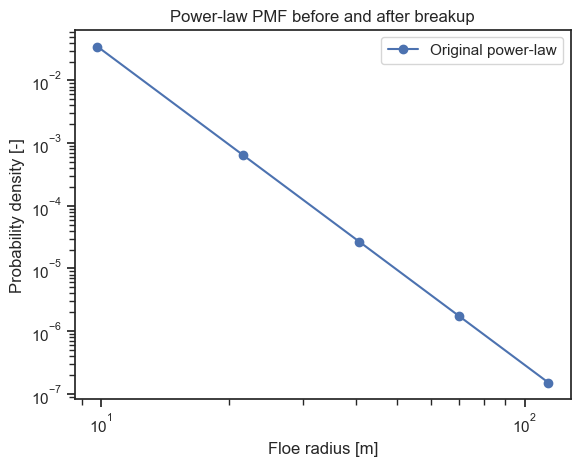

In [ ]:
# x_new = x[x <= r_max]
# new_power_law_pdf = get_power_law_pdf(x_new, alpha, r_min, r_max)

plt.plot(x_orig, power_law_orig, marker='o', label='Original power-law')
# plt.plot(x_new, new_power_law_pdf, ls='--', label='New power-law PMF after breakup')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Floe radius [m]')
plt.ylabel('Probability density [-]')
plt.legend()
plt.title('Power-law PMF before and after breakup')

np.float64(0.32226146812610895)

In [ ]:
(fsd_pdf*binwidths).sum()

<xarray.DataArray 'afsd' ()> Size: 8B
array(1.)
Coordinates:
    TLAT     float32 4B -72.63
    TLON     float32 4B 254.9
    ULON     float32 4B -105.0
    ULAT     float32 4B -72.58

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # x = bin centers (NFSD)
# # afsd = pmf-like array you showed

# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.plot(x, afsd, 'o-')
# plt.xlabel('Floe radius (m)')
# plt.title('pmf / afsd (linear)')

# plt.subplot(1,2,2)
# plt.loglog(x, afsd, 'o-')
# plt.xlabel('Floe radius (m)')
# plt.title('pmf / afsd (log-log)')
# plt.show()

# # cumulative / survival
# cdf = np.cumsum(afsd)
# surv = 1 - cdf + afsd[0] * 0  # adjust if necessary
# plt.figure()
# plt.loglog(x, 1-np.cumsum(afsd), 'o-')
# plt.title('Survival (1-CDF)')
# plt.show()

In [ ]:
# # Log-spaced bins for plotting histogram
# # bins = np.logspace(np.log10(x_sample.min()), np.log10(x_sample.max()), 50)

# # Histogram of samples
# hist_counts, bin_edges = np.histogram(samples, bins=bins, density=True)
# bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])  # log-midpoints

# # Normalize original FSD to probability density over bins
# fsd_sub_norm = afsd_sub / np.sum(afsd_sub * np.diff(np.hstack([x_sub, x_sub[-1]+1])))

# plt.figure(figsize=(7,5))
# plt.plot(bin_centers, hist_counts, 'o', label='Sampled histogram')
# plt.plot(x_sample, prob, '-', label='Interpolated FSD')
# plt.plot(x_sub, fsd_sub_norm, 's', label='Original FSD')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Floe radius [m]')
# plt.ylabel('Probability density')
# plt.legend()
# plt.show()

Estimated alpha: 5.084651142779169
Observed p11 = 1.81801366e-06
Observed p12 = 0.00813157004
Minimum possible p12 under truncated power-law = 1.3301322235921155e-05
No finite b can make p12 ≤ p11 for this alpha.


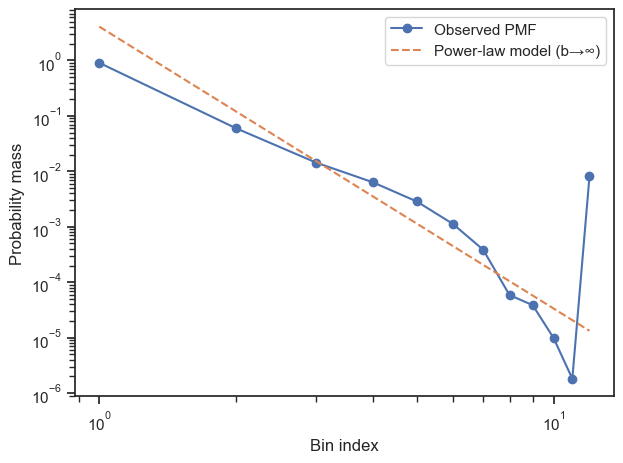

In [ ]:
# import numpy as np

# from scipy.optimize import curve_fit
# import matplotlib.pyplot as plt

# # -----------------------------------------------------
# # Data
# # -----------------------------------------------------
# pmf = np.array([
#     9.06571720e-01, 5.99003563e-02, 1.44024435e-02, 6.36020002e-03,
#     2.85942344e-03, 1.13243140e-03, 3.85797267e-04, 5.88028460e-05,
#     3.84877279e-05, 9.89180454e-06, 1.81801366e-06, 8.13157004e-03
# ])

# x = np.arange(1, len(pmf)+1)     # Assume x = 1..12
# pmf11 = pmf[:11]                 # first 11 bins
# x11 = x[:11]

# # -----------------------------------------------------
# # Fit alpha by linear regression on log-log
# # -----------------------------------------------------
# def model(x, a, c):
#     return a * np.log(x) + c

# popt, _ = curve_fit(model, x11, np.log(pmf11))
# alpha_hat = -popt[0]
# print("Estimated alpha:", alpha_hat)

# # -----------------------------------------------------
# # Compute best possible prediction for bin 12
# # under *any* truncated power-law
# # -----------------------------------------------------
# alpha = alpha_hat

# # Minimum normalisation constant occurs as b → ∞
# C_min = (alpha - 1)

# # Minimum possible tail value:
# p12_min = C_min * (12 ** -alpha)

# print("Observed p11 =", pmf[10])
# print("Observed p12 =", pmf[11])
# print("Minimum possible p12 under truncated power-law =", p12_min)

# if p12_min <= pmf[10]:
#     print("A finite b CAN exist.")
# else:
#     print("No finite b can make p12 ≤ p11 for this alpha.")

# # -----------------------------------------------------
# # Plot
# # -----------------------------------------------------
# plt.figure()
# plt.loglog(x, pmf, "o-", label="Observed PMF")

# # model tail using alpha_hat, C_min (b→∞)
# plaw = C_min * x**(-alpha)
# plt.loglog(x, plaw, "--", label="Power-law model (b→∞)")

# plt.xlabel("Bin index")
# plt.ylabel("Probability mass")
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# \lambda = \frac{gT^2}{2\pi}


## Wave-dependent growth

In [498]:
gravity = 9.81 # Gravitational acceleration
rho_i = 917 # Ice density (kg/m^3)
rho_w = 1026 # Water density (kg/m^3)
tensile_param = 0.167

amplitude_vec = np.logspace(-10, 1, 50)  
peak_period = np.logspace(0, 1.4, 50)  
peak_freq = 1 / peak_period

def disperion_relation(period):
    wavelength = gravity / (2 * np.pi) * period**2
    return wavelength

def wave_dep_growth(amplitude, peak_period):
    Lambda = disperion_relation(peak_period)
    f_peak = 1 / peak_period
    r_max = 0.5 * np.sqrt(tensile_param * gravity / (np.pi**5 * rho_i * amplitude * 2))/f_peak**2
    return r_max


def shen_2001(amplitude, period, thickness=0.1, C_d=0):
    """
    Calculate some wave-ice interaction parameter following Shen (2001) for regular waves.

    Parameters
    ----------
    amplitude : float
        Wave amplitude [m].
    peak_freq : float
        Peak wave frequency [Hz].
    tensile_param : float, optional
        Bonding strength/Tensile parameter for ice, default is 0.167.
    thickness : float, optional
        Ice thickness [m], default is 0.
    C_d : float, optional
        Drag coefficient, default is 0.

    Returns
    -------
    D_max : float
        Limiting pancake ice diameter [m].
    """
    C_2 = tensile_param
    L = disperion_relation(period) # Wavelength [m]
    T = period # Wave period [s]
    A = amplitude # [m]
    h = thickness # [m]
    D_max = np.sqrt( 2 * C_2 * L**2 / ( np.pi**3 * amplitude * gravity * (rho_i + C_d * rho_w * A/h)))
    return D_max

In [499]:

print(shen_2001(0.1, 100))
wave_dep_growth(0.1, 100)

54.02793788128476


np.float64(27.013968940642375)

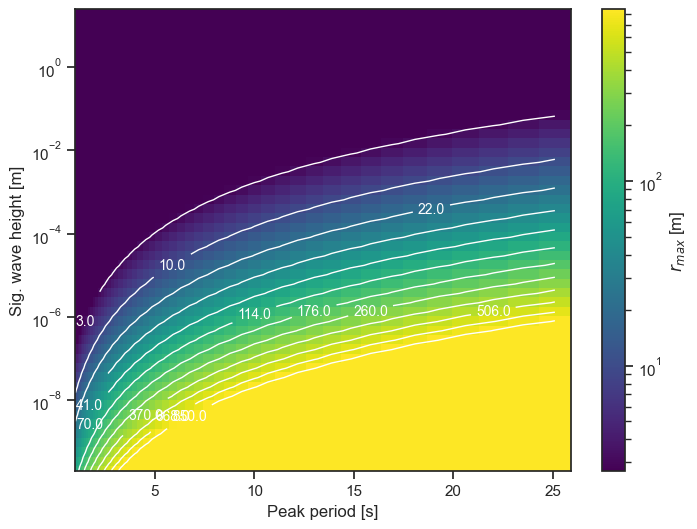

In [510]:
from matplotlib.colors import LogNorm

# 2D grid
A, F = np.meshgrid(amplitude_vec, peak_period)  # A = amplitude, F = period
R = shen_2001(A, F)/2  # example, adjust to your function

plt.figure(figsize=(8,6))

# Heatmap
pcm = plt.pcolormesh(F, 2*A, R, shading='auto', cmap='viridis', norm=LogNorm(vmin=NFSD[0], vmax=NFSD[-1]))  # F = x, A = y
plt.colorbar(pcm, label="$r_{max}$ [m]")

# Contours
contour_levels = np.round(NFSD, 0)
CS = plt.contour(F, 2*A, R, levels=contour_levels, colors='white', linewidths=1)
plt.clabel(CS, inline=True, fontsize=10, fmt="%.1f")

plt.yscale('log')
plt.xlabel("Peak period [s]")
plt.ylabel("Sig. wave height [m]")
plt.show()

Text(0.5, 1.0, 'Wave amplitude = 0.1 m')

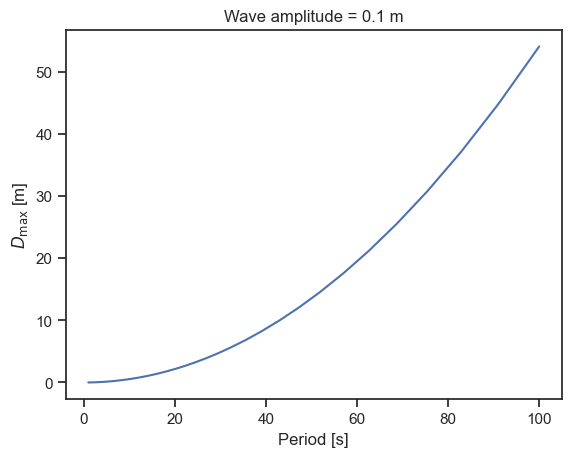

In [ ]:
shen_radius = shen_2001(amplitude=0.1, period=peak_period)
plt.plot(peak_period, shen_radius)
plt.xlabel('Period [s]')
plt.ylabel('$D_{\max}$ [m]')
plt.title('Wave amplitude = 0.1 m')

## Welding of floes

In [ ]:
floe_binwidth

array([  5.24380864,   8.97627793,  14.77108039,  23.35454522,
        35.45693244,  51.64931451,  72.11731757,  96.40148125,
       123.16584052, 150.07408868, 173.86383857, 190.67180596])

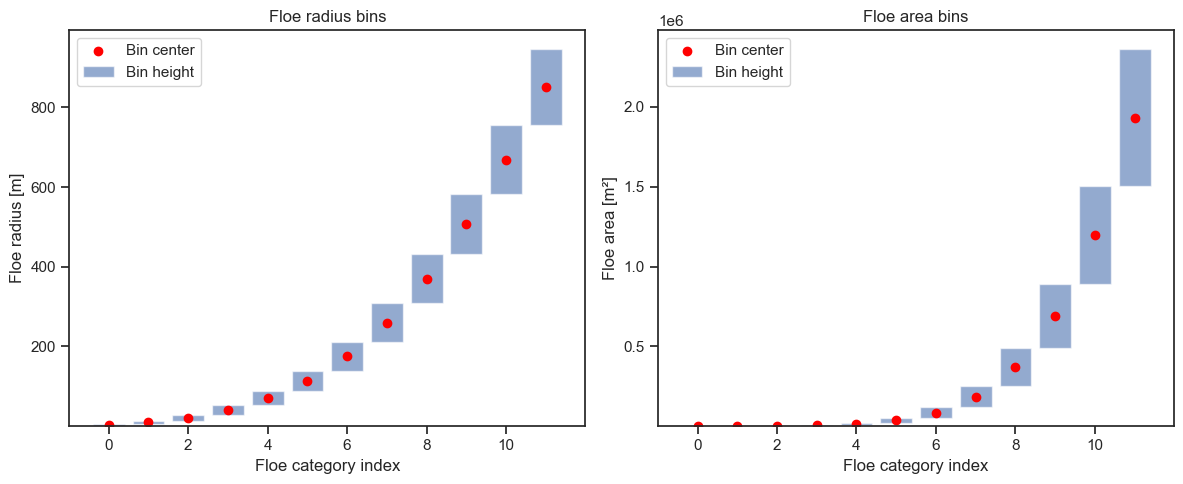

In [ ]:
floe_binwidth, floe_rad_l, floe_rad_r, floe_area_c, floe_area_l, floe_area_h = ciceBinWidths(NFSD)
# return BinWidths, BinLeft, BinRight, floe_area_c, floe_area_l, floe_area_h

# floe_rad_l, floe_rad_c, floe_rad_h, floe_area_c, floe_area_l, floe_area_h = ciceBinWidths(NFSD)
floe_rad_c = NFSD
# Plot histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Floe radius bins
axs[0].bar(range(len(NFSD)), floe_rad_h - floe_rad_l, bottom=floe_rad_l, width=0.8, alpha=0.6, label='Bin height')
axs[0].scatter(range(len(NFSD)), floe_rad_c, color='red', label='Bin center')
axs[0].set_xlabel('Floe category index')
axs[0].set_ylabel('Floe radius [m]')
axs[0].set_title('Floe radius bins')
axs[0].legend()

# Floe area bins
axs[1].bar(range(len(NFSD)), floe_area_h - floe_area_l, bottom=floe_area_l, width=0.8, alpha=0.6, label='Bin height')
axs[1].scatter(range(len(NFSD)), floe_area_c, color='red', label='Bin center')
axs[1].set_xlabel('Floe category index')
axs[1].set_ylabel('Floe area [m²]')
axs[1].set_title('Floe area bins')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
N_c = 5
N_f = 12
frzmlt = 100
dt = 3600*6
# iweld = 
aicen = [0.2, 0.2, 0.2, 0.2, 0.2]
# Initialize FSD tracers
trcrn = np.ones((N_f, N_c))
trcrn /= trcrn.sum(axis=0, keepdims=True)  # normalize per column (thickness category)
trcrn /= floe_binwidth[:, None]           # divide by bin width to get density
trcrn = icepack_cleanup_fsdn(trcrn, puny=1e-12, c0=0.0)
trcrn_init = trcrn.copy()
print(trcrn)

[[0.07475443 0.07475443 0.07475443 0.07475443 0.07475443]
 [0.04367043 0.04367043 0.04367043 0.04367043 0.04367043]
 [0.0265382  0.0265382  0.0265382  0.0265382  0.0265382 ]
 [0.01678465 0.01678465 0.01678465 0.01678465 0.01678465]
 [0.01105561 0.01105561 0.01105561 0.01105561 0.01105561]
 [0.00758961 0.00758961 0.00758961 0.00758961 0.00758961]
 [0.00543556 0.00543556 0.00543556 0.00543556 0.00543556]
 [0.00406631 0.00406631 0.00406631 0.00406631 0.00406631]
 [0.00318268 0.00318268 0.00318268 0.00318268 0.00318268]
 [0.00261203 0.00261203 0.00261203 0.00261203 0.00261203]
 [0.00225463 0.00225463 0.00225463 0.00225463 0.00225463]
 [0.00205588 0.00205588 0.00205588 0.00205588 0.00205588]]


In [ ]:
import numpy as np

def compute_iweld(floe_area_c, floe_area_l, floe_area_h):
    """
    Compute the floe size category index for welded floes.

    Parameters
    ----------
    floe_area_c : ndarray, shape (nfsd,)
        Area of each floe size category.
    floe_area_l : ndarray, shape (nfsd,)
        Lower bounds of floe area bins.
    floe_area_h : ndarray, shape (nfsd,)
        Upper bounds of floe area bins.

    Returns
    -------
    iweld : ndarray, shape (nfsd, nfsd)
        Index of floe category resulting from welding of categories (i,j).
    """
    nfsd = len(floe_area_c)
    iweld = -999 * np.ones((nfsd, nfsd), dtype=int)

    for n in range(nfsd):
        for m in range(nfsd):
            combined_area = floe_area_c[n] + floe_area_c[m]
            assigned = False
            for k in range(nfsd - 1):
                if floe_area_l[k] <= combined_area < floe_area_h[k]:
                    iweld[n, m] = k
                    assigned = True
                    # print("n = ", n)
                    # print("m = ", m)
                    # print("combined_area = ", combined_area)
                    # print("assigned = ", assigned)
                    break  # exit loop once assigned
            if not assigned:
                # if combined area exceeds largest bin
                if combined_area >= floe_area_l[-1]:
                    iweld[n, m] = nfsd - 1  # Python 0-based index
                    print("Exceeds largest bin")
    return iweld
iweld = compute_iweld(floe_area_c, floe_area_l, floe_area_h)
iweld

Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin
Exceeds largest bin


array([[ 1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 1,  2,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 2,  2,  3,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 3,  3,  3,  4,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 4,  4,  4,  4,  5,  5,  6,  7,  8,  9, 10, 11],
       [ 5,  5,  5,  5,  5,  6,  7,  7,  8,  9, 10, 11],
       [ 6,  6,  6,  6,  6,  7,  7,  8,  8,  9, 10, 11],
       [ 7,  7,  7,  7,  7,  7,  8,  8,  9,  9, 10, 11],
       [ 8,  8,  8,  8,  8,  8,  8,  9,  9, 10, 11, 11],
       [ 9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 11, 11],
       [10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11],
       [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]])

In [ ]:
combined_area = floe_area_c[1] + floe_area_c[0]
combined_area

print(floe_area_l < combined_area)
floe_area_h > combined_area

print(floe_area_l[1])
print(floe_area_h[1])
combined_area

[ True  True False False False False False False False False False False]
74.44635762311304
538.8413077139116


np.float64(343.87284885006886)

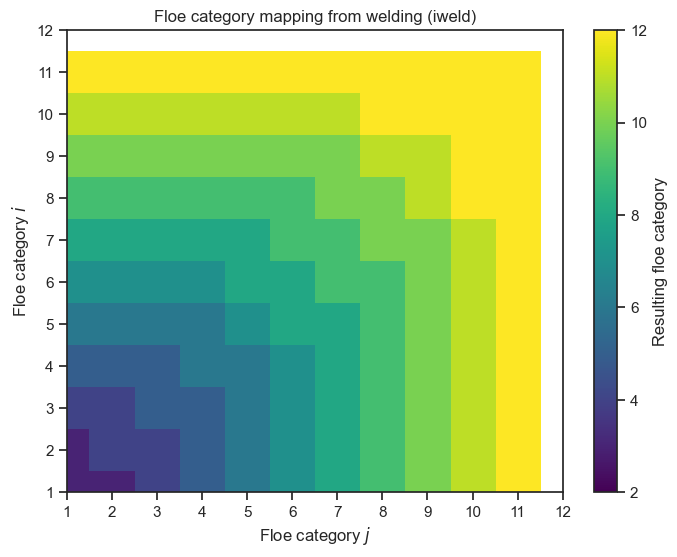

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Example iweld array
iweld_plot = iweld.copy()
iweld_plot = iweld_plot.astype(float)
iweld_plot[iweld_plot == -999] = np.nan  # mask unassigned values
iweld_plot += 1

plt.figure(figsize=(8, 6))
cmap = 'viridis'  # categorical colormap
im = plt.imshow(iweld_plot, origin='lower', cmap=cmap, aspect='auto')

plt.colorbar(im, label="Resulting floe category")
plt.xlabel("Floe category $j$")
plt.ylabel("Floe category $i$")
plt.title("Floe category mapping from welding (iweld)")
plt.xticks(np.arange(1,13))
plt.yticks(np.arange(1,13))
plt.xlim([1,12])
plt.ylim([1,12])
plt.show()

In [ ]:
def icepack_cleanup_fsd(afsdn, tr_fsd=True, ncat=None):
    """
    Clean up small values and renormalize FSD.

    Parameters
    ----------
    afsdn : ndarray, shape (nfsd, ncat)
        Floe size distribution tracer.
    tr_fsd : bool
        Whether to apply the cleaning (equivalent to tr_fsd flag in Fortran).
    ncat : int, optional
        Number of thickness categories. If None, inferred from afsdn.

    Returns
    -------
    afsdn : ndarray
        Cleaned FSD array (in-place modification possible).
    """
    if ncat is None:
        ncat = afsdn.shape[1]

    subname = "(icepack_cleanup_fsd)"

    if tr_fsd:
        for n in range(ncat):
            afsdn[:, n] = icepack_cleanup_fsdn(afsdn[:, n])
            # if icepack_warnings_aborted(subname):
                # return afsdn

    return afsdn


def icepack_cleanup_fsdn(afsd, puny=1e-12, c0=0.0):
    """
    Clean up small values and renormalize a single FSD column.

    Parameters
    ----------
    afsd : ndarray, shape (nfsd,)
        Floe size distribution tracer for a single thickness category.
    puny : float
        Small threshold below which values are set to zero.
    c0 : float
        Value to assign for zeroed elements (usually 0.0).

    Returns
    -------
    afsd_clean : ndarray
        Cleaned and normalized FSD column.
    """
    afsd_clean = afsd.copy()
    
    # Zero out tiny values
    afsd_clean[afsd_clean < puny] = c0
    
    tot = np.sum(afsd_clean)
    
    if tot > puny:
        afsd_clean /= tot  # normalize
    else:
        afsd_clean[:] = c0  # ice-free cell
    
    return afsd_clean

def fsd_weld_thermo(dt, frzmlt, aicen, trcrn, floe_area_c, iweld, aminweld=0.05, c_weld_param="icepack", puny=1e-12):
    """
    Update FSD due to welding under freezing conditions.

    Parameters
    ----------
    dt : float
        Time step [s].
    frzmlt : float
        Freezing/melting potential [W/m^2].
    aicen : ndarray, shape (ncat,)
        Ice concentration per thickness category.
    trcrn : ndarray, shape (nfsd, ncat)
        FSD tracers.
    floe_area_c : ndarray, shape (nfsd,)
        Area of each floe size category.
    iweld : ndarray, shape (nfsd, nfsd)
        Index mapping of welded floe categories (i+j -> k).
    aminweld : float
        Minimum ice concentration likely to weld.
    c_weld : float
        Welding rate coefficient [m^-2 s^-1].
    puny : float
        Small number to avoid division by zero.

    Returns
    -------
    trcrn : ndarray
        Updated FSD tracers.
    d_afsd_weld : ndarray
        Change in FSD due to welding.
    """
    if c_weld_param == "icepack":
        # Default is 1e-8 in Icepack but is reported to be 0.01 in Roach et al. (2018)
        c_weld = 1e-8
    else:
        c_weld = 0.01

    nfsd, ncat = trcrn.shape
    d_afsd_weld = np.zeros(nfsd)
    trcrn_out = np.zeros((nfsd, ncat))
    afsdn = np.zeros((nfsd, ncat))

    afsdn_init = trcrn.copy()
    
    for n in range(ncat):
        afsdn[:,n] = trcrn[:, n].copy()
        d_afsd_weld = np.zeros_like(nfsd)
        d_afsdn_weld = np.zeros_like(afsdn)
        
        # Only proceed if conditions allow welding
        if (frzmlt > puny) and (aicen[n] > aminweld) and (np.sum(afsdn[:-1]) > puny):
            afsd_init = afsdn[:,n].copy()
            afsd_tmp = afsd_init.copy()
            afsd_tmp[afsd_tmp < puny] = 0.0
            afsd_tmp /= np.sum(afsd_tmp)
            
            elapsed_t = 0.0
            while elapsed_t < dt:
                # adaptive sub-timestep
                nfsd_tmp = afsd_tmp / floe_area_c
                stability = np.where(afsd_tmp > puny, nfsd_tmp / (c_weld * afsd_tmp * aicen[n]), 1e12)
                subdt = min(np.min(stability), dt - elapsed_t)
                
                # compute gain/loss
                gain = np.zeros(nfsd)
                loss = np.zeros(nfsd)
                
                for i in range(nfsd):
                    for j in range(nfsd):
                        k = iweld[i, j]
                        if k > i:
                            kern = c_weld * floe_area_c[i] * aicen[n]
                            loss[i] += kern * afsd_tmp[i] * afsd_tmp[j]
                            gain[k] += kern * afsd_tmp[i] * afsd_tmp[j]
                
                # update afsd
                afsd_tmp += subdt * (gain - loss)
                afsd_tmp[afsd_tmp < puny] = 0.0
                afsd_tmp /= np.sum(afsd_tmp)
                
                elapsed_t += subdt
                
                # exit if all in largest floe category
                if afsd_tmp[-1] > 1.0 - puny:
                    break
            
            afsdn[:,n] = afsd_tmp.copy()
            afsdn =  icepack_cleanup_fsd(afsdn)
            # afsdn_2d = afsdn[:, None]  # shape becomes (nfsd, 1)
            

            d_afsdn_weld[:,n] = afsdn[:,n] - afsdn_init[:,n]
            trcrn_out[:, n] = afsdn[:,n]
        
        # accumulate total welding effect
        # d_afsd_weld += aicen[n] * d_afsdn_weld[:,n]
    trcrn_out = icepack_cleanup_fsdn(trcrn_out, puny=1e-12, c0=0.0)
    return trcrn_out, d_afsdn_weld

trcrn_new, d_afsdn_weld = fsd_weld_thermo(dt, frzmlt, aicen, trcrn.copy(), floe_area_c, iweld, aminweld=0.05, puny=1e-12)

In [ ]:
# trcrn

In [ ]:
fsd_init = trcrn.sum(axis=1)
fsd_init

fsd_new = trcrn_new.sum(axis=1)
fsd_new

array([0.37317147, 0.21690092, 0.13055903, 0.08120812, 0.05195878,
       0.03397126, 0.01879596, 0.01412572, 0.00904044, 0.00585542,
       0.00229349, 0.06211938])

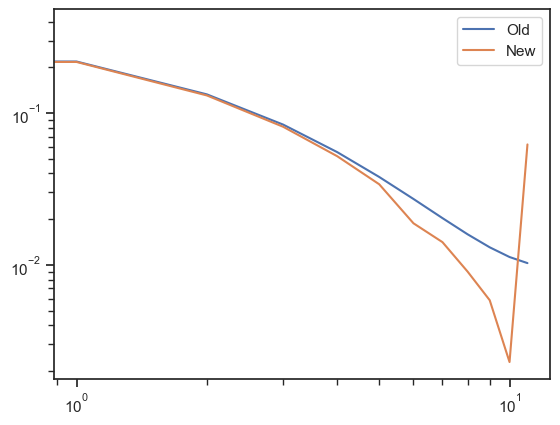

In [ ]:
plt.plot(fsd_init, label='Old')
plt.plot(fsd_new, label='New')
plt.xscale('log')
plt.yscale('log')
plt.legend()


In [ ]:
fsd_new.sum()

np.float64(1.0)

In [ ]:
fsd_init.sum()

# history[0].sum()

np.float64(0.9999999999999999)

/var/folders/6x/r2s0nyrs3k59d38v1vxchxmc0000gp/T/ipykernel_3223/4119578855.py:126: RuntimeWarning: invalid value encountered in divide
  stability = np.where(afsd_tmp > puny, nfsd_tmp / (c_weld * afsd_tmp * aicen[n]), 1e12)
/var/folders/6x/r2s0nyrs3k59d38v1vxchxmc0000gp/T/ipykernel_3223/4119578855.py:126: RuntimeWarning: invalid value encountered in divide
  stability = np.where(afsd_tmp > puny, nfsd_tmp / (c_weld * afsd_tmp * aicen[n]), 1e12)
/var/folders/6x/r2s0nyrs3k59d38v1vxchxmc0000gp/T/ipykernel_3223/4119578855.py:126: RuntimeWarning: invalid value encountered in divide
  stability = np.where(afsd_tmp > puny, nfsd_tmp / (c_weld * afsd_tmp * aicen[n]), 1e12)
/var/folders/6x/r2s0nyrs3k59d38v1vxchxmc0000gp/T/ipykernel_3223/4119578855.py:126: RuntimeWarning: invalid value encountered in divide
  stability = np.where(afsd_tmp > puny, nfsd_tmp / (c_weld * afsd_tmp * aicen[n]), 1e12)
/var/folders/6x/r2s0nyrs3k59d38v1vxchxmc0000gp/T/ipykernel_3223/4119578855.py:126: RuntimeWarning: inval

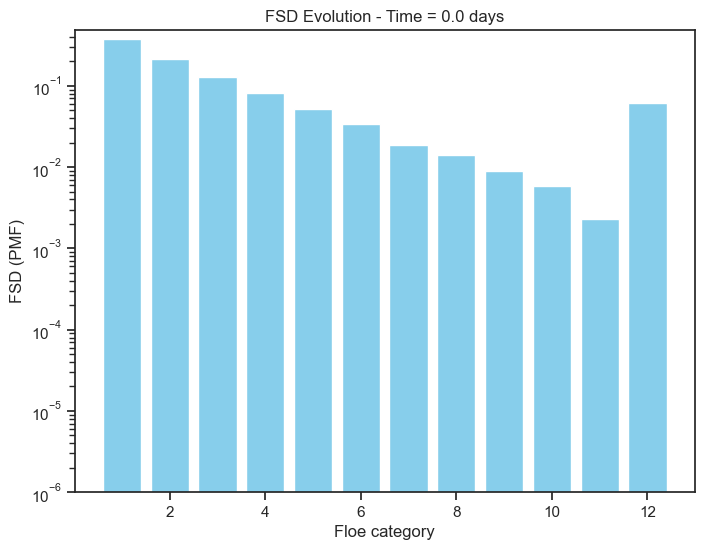

In [511]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Example parameters
N_f = len(floe_area_c)      # number of floe categories
N_c = len(aicen)            # number of thickness categories
nt = 50                     # number of timesteps
dt_step = dt                # timestep duration
frzmlt = 1e-3


# Initialize FSD
trcrn_t = trcrn.copy()
history = np.zeros((nt, N_f))  # store total FSD over floe sizes
history_ra = np.zeros(nt) 

# Loop over timesteps to compute FSD evolution
for t in range(nt):
    trcrn_t, d_afsdn_weld = fsd_weld_thermo(
        dt_step, frzmlt, aicen, trcrn_t, floe_area_c, iweld,
        aminweld=0.05, puny=1e-12
    )
    history[t, :] = trcrn_t.sum(axis=1)
    history_ra[t] = get_representative_floe_size(NFSD_in=NFSD, afsd_in=history[t, :]/floe_binwidth, aice_in=1.0)

# --- Create animation ---
fig, ax = plt.subplots(figsize=(8,6))
lines = ax.bar(np.arange(N_f)+1, history[0, :], color='skyblue')
ax.set_xlabel('Floe category')
ax.set_ylabel('FSD (PMF)')
ax.set_title('FSD Evolution Over Time')
ax.set_ylim(1e-6, history.max()*1.1)
ax.set_yscale('log')

def update(frame):
    for rect, h in zip(lines, history[frame, :]):
        rect.set_height(h)
    ax.set_title(f'FSD Evolution - Time = {frame*dt_step/3600/24:.1f} days')
    return lines

ani = FuncAnimation(fig, update, frames=nt, blit=False, interval=200)
HTML(ani.to_jshtml())  # or ani.to_html5_video()

Text(0, 0.5, 'Representative floe radius [m]')

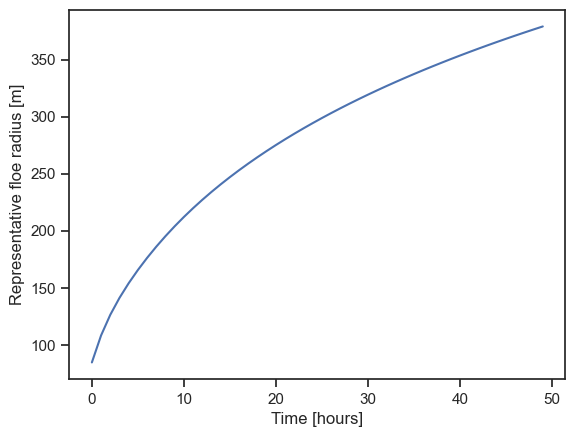

In [513]:

plt.plot(range(nt), history_ra)
plt.xlabel('Time [hours]')
plt.ylabel("Representative floe radius [m]")

In [ ]:
# COMPARE BOTH WELDING RATES
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Example parameters
N_f = len(floe_area_c)      # number of floe categories
N_c = len(aicen)            # number of thickness categories
nt = 10                     # number of timesteps
dt_step = dt                # timestep duration
frzmlt = 1


# Initialize FSD
trcrn_t = trcrn.copy()
history_icepack = np.zeros((nt, N_f))  # store total FSD over floe sizes
history_ra_icepack = np.zeros(nt)
history_roach = np.zeros((nt, N_f))  # store total FSD over floe sizes
history_ra_roach = np.zeros(nt)
                         
# Loop over timesteps to compute FSD evolution
for t in (range(nt)):
    print(t)
    trcrn_t, d_afsdn_weld = fsd_weld_thermo(
        dt_step, frzmlt, aicen, trcrn_t, floe_area_c, iweld, c_weld_param="icepack",
        aminweld=0.05, puny=1e-12
    )
    history_icepack[t, :] = trcrn_t.sum(axis=1)
    history_ra_icepack[t] = get_representative_floe_size(NFSD_in=NFSD, afsd_in=history[t, :]/floe_binwidth, aice_in=1.0)

    trcrn_t, d_afsdn_weld = fsd_weld_thermo(
        dt_step, frzmlt, aicen, trcrn_t, floe_area_c, iweld, c_weld_param="roach",
        aminweld=0.05, puny=1e-12
    )
    history_roach[t, :] = trcrn_t.sum(axis=1)
    history_ra_roach[t] = get_representative_floe_size(NFSD_in=NFSD, afsd_in=history[t, :]/floe_binwidth, aice_in=1.0)

# # --- Create animation ---
# fig, ax = plt.subplots(figsize=(8,6))
# lines = ax.bar(np.arange(N_f)+1, history_icepack[0, :], color='skyblue')

# lines = ax.bar(np.arange(N_f)+1, history_roach[0, :], color='red')
# ax.set_xlabel('Floe category')
# ax.set_ylabel('FSD (sum over thickness categories)')
# ax.set_title('FSD Evolution Over Time')
# ax.set_ylim(1e-12, history.max()*1.1)
# ax.set_yscale('log')

# def update(frame):
#     for rect, h in zip(lines, history[frame, :]):
#         rect.set_height(h)
#     ax.set_title(f'FSD Evolution - Time = {frame*dt_step/3600/24:.1f} days')
#     return lines

# ani = FuncAnimation(fig, update, frames=nt, blit=False, interval=200)
# HTML(ani.to_jshtml())  # or ani.to_html5_video()

0


/var/folders/6x/r2s0nyrs3k59d38v1vxchxmc0000gp/T/ipykernel_3223/4119578855.py:126: RuntimeWarning: invalid value encountered in divide
  stability = np.where(afsd_tmp > puny, nfsd_tmp / (c_weld * afsd_tmp * aicen[n]), 1e12)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/daynd/miniconda3/envs/notebook_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/6x/r2s0nyrs3k59d38v1vxchxmc0000gp/T/ipykernel_3223/944535492.py", line 33, in <module>
    trcrn_t, d_afsdn_weld = fsd_weld_thermo(
                            ^^^^^^^^^^^^^^^^
  File "/var/folders/6x/r2s0nyrs3k59d38v1vxchxmc0000gp/T/ipykernel_3223/4119578855.py", line None, in fsd_weld_thermo
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/daynd/miniconda3/envs/notebook_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2194, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/daynd/miniconda3/envs/notebook_env/lib/python3.11/site-packages/IPython/core

In [ ]:

plt.plot(range(nt), history_ra_icepack)
plt.plot(range(nt), history_ra_roach)
plt.xlabel('Time [hours]')
plt.ylabel("Representative floe radius")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.interpolate import interp1d

# # Original x and afsd
# x = ds['NFSD'].values
# afsd = ds['afsd'].where(ds['aice'] > 0.15).where(ds['TLAT'] < 0, drop=True).mean(dim=['ni', 'nj'])

# # Take subset if needed
# x_sub = x[0:-3]
# afsd_sub = afsd[0:-3]

# # Interpolation grid: higher resolution (log-spaced for log-log plotting)
# x_sample= np.logspace(np.log10(x_sub[0]), np.log10(x_sub[-1]), 1000)  # 1000 points

# # Linear interpolation in log-log space for smooth behavior
# interp_func = interp1d(np.log(x_sub), np.log(afsd_sub), kind='linear', fill_value='extrapolate')
# afsd_fine = np.exp(interp_func(np.log(x_fine)))

# # Normalize to make it a probability distribution
# prob = afsd_fine / afsd_fine.sum()

# # Draw samples
# N_samples = 10000
# samples = np.random.choice(x_fine, size=N_samples, p=prob)

# # Plot histogram to check
# plt.hist(samples, bins=x_fine, density=True, alpha=0.5, label='Sampled')
# plt.plot(x_fine, afsd_fine / afsd_fine.sum(), 'r', label='Interpolated PDF')
# plt.xlabel('Floe radius [m]')
# plt.ylabel('Probability density')
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.show()

In [ ]:
# import xarray as xr
# import numpy as np
# import matplotlib.pyplot as plt

# # # -------------------------------
# # # Select the data
# # # -------------------------------
# # # Floe size bins
# # x = ds['NFSD'].values

# # # Area-weighted FSD for southern hemisphere and ice fraction > 0.15
# # fsd = ds['afsd'].where(ds['aice'] > 0.15).where(ds['TLAT'] < 0, drop=True).mean(dim=['ni', 'nj'])

# # # Optionally remove last few bins if they are zeros/artifacts
# # x_sample = x#[0:-1]
# # fsd_sample = fsd#[0:-1]

# # -------------------------------
# # # Normalize FSD to probabilities
# # # -------------------------------
# # prob = fsd_sample / fsd_sample.sum()
# # prob = prob / prob.sum()
# # prob = np.atleast_1d(prob)

# # # -------------------------------
# # # Draw representative samples
# # # -------------------------------
# # N_samples = 10000
# # samples = np.random.choice(x_sample, size=N_samples, p=prob)

# # -------------------------------
# # Estimate alpha using your function
# # -------------------------------
# G = geometric_mean(samples)
# alpha_est, G_est = estimate_power_law_alpha(samples, mean=G)

# print(f"Estimated power-law exponent: {alpha_est:.3f}")
# print(f"Representative floe size (geometric mean): {G_est:.2f} m")

# # -------------------------------
# # Compute power-law PDF for plotting
# # -------------------------------
# a = x_sample.min()
# b = x_sample.max()
# power_law = power_law_pdf(x_in=x_sample, alpha_in=alpha_est, a_in=a, b_in=b)

# plt.hist(samples, bins=x, density=True)
# plt.plot(x_sample, prob, 'o', label='CICE FSD')
# plt.plot(x_sample, power_law, '-', label='Fitted power-law PDF')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Floe radius [m]')
# plt.ylabel('Probability density')
# plt.legend()
# plt.show()

In [ ]:
# samples.min()

In [ ]:
# def power_law_pdf(x_in, alpha_in, a_in, b_in):
#     C = (alpha_in - 1) * a**(alpha_in - 1) / (1 - (a_in / b_in)**(alpha_in - 1))
#     print(C)
#     return C * x_in**(-alpha_in)

# power_law = power_law_pdf(x_in=x, alpha_in=alpha, a_in=a, b_in=b)

# plt.plot(x, afsd, '-', label='PDF from CICE')
# plt.plot(x, power_law, '-', label='Fitted power-law PDF')

# plt.hist(samples, bins=x, density=True, alpha=0.5, color='gray', label='Sample histogram')


# plt.xlabel('Floe radius [m]')
# plt.ylabel('Probability density')
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.show()


In [ ]:
# alpha

## References
- Rothrock and Thorndike, *JGR:Oceans* (1984)
- Kohout and Meylan, JGR? (2008)
- Horvat and Tziperman, *TC* (2015)
- Stern et al., ** (2018)
- Montiel and Mokus, *Phil. Trans.* (2022)
- Tremblay and Roach, *EGU* (2024)
- 